In [ ]:
## Script Index: S6
## Author: Liu Yue
## Date: 10/10/2016
## Python Version: Anaconda 4.2.0, python 3.5


""" 
    This script merges datasets from ZOL and from TalkIngData. 
    Initial model is explored to test the feasibility of kNN and CF
"""

In [1]:
""" Data pre-processing """

def spec_format(lst):
    """ Method to convert Chinese to int"""
    lst2 = [line[:11] for line in lst if len(line)>11]
    for line in lst2:
        try:
            line[2] = float(line[2].replace("英寸",""))
        except Exception:
            line[2] = 0
        try:
            line[3] = int(line[3].replace("像素","").upper().split("X")[1])
        except Exception:
            line[3] = 0
        try:
            line[4] = int(line[4].replace("万像素",""))
        except Exception:
            line[4] = 0
        try:
            line[5] = int(line[5].replace("万像素",""))
        except Exception:
            line[5] = 0
        line[6] = count_core(line[6])
        line[7] = count_ram(line[7])
        try:
            line[8] = int(line[8].upper().replace("MAH",""))
        except Exception:
            line[8] = 0
        try:
            line[9] = int(line[9])
        except Exception:
            line[9] = 999
        try:
            line[10] = int(line[10]) - int(line[10])%50
        except Exception:
            line[10] = 0
        # Remove zol_index
        del line[1]
    return([line for n,line in enumerate(lst2) if line not in lst2[:n]])# Remove duplicates
def count_core(s):
    """ Method to count # cores of phone"""
    n = 1
    if s == "":
        return(n)
    if "八" in s:
        n = 8
    elif "四" in s:
        n = 4
    return(n)
def count_ram(s):
    """ Method to count RAM of phone"""
    n = 0
    if s == "":
        return(n)
    try:
        if "GB" in s:
            n = int(s.upper().replace("GB",""))
        elif "MB" in s:
            n = int(s.upper().replace("MB",""))/1024
        return(n)
    except Exception:
        return(0)
def same_index(a, b):
    """ Method to check whether the two zol device models have the assigned Talking Data index """
    if a==b:
        return(False)
    if a[0] != b[0]:
        return(False)
    return(True)
def remove_zol_line(a,b,lst):
    """ Method to check which to be removed: lower camera pixel, lower ram, higher price, younger age """
    back_a = a[4]
    back_b = b[4]
    ram_a = a[6]
    ram_b = b[6]
    price_a = a[9]
    price_b = b[9]
    age_a = a[8]
    age_b = b[8]
    if back_a > back_b:
        removal = b
    elif back_a < back_b:
        removal = a
    elif ram_a > ram_b:
        removal = b
    elif ram_a < ram_b:
        removal = a
    elif price_a == 0:
        removal = a
    elif price_b == 0:
        removal = b         
    elif price_a > price_b:
        removal = a
    elif price_a < price_b:
        removal = b
    elif age_a > age_b:
        removal = b
    elif age_a < age_b:
        removal = a
    else:
        removal = None
    if removal in lst:
        lst.remove(removal)

"""Load scraped data"""
import csv
with open('S5_zol phone device specidication.csv', newline='',encoding='utf-8') as f:
    file = csv.reader(f)
    spec = list(file)
spec[0][0] = spec[0][0].replace(u'\ufeff', '') # Remove Byte Order Mark character at start of file
print('Sample original data', spec[:1]) 

""" data formatting and cleasing """
lst = spec_format(spec)
lst = [line for line in lst if line[9]>0 and line[8]>0]
while len(lst) > len(set(line[0] for line in lst)):
    for line1 in lst:
        for line2 in lst:
            if same_index(line1, line2):
                remove_zol_line(line1, line2, lst)
print("\nAttributes:")
print("assigned_index, SCREEN SIZE, SCREEN RESOLUTION, BACK CAM, FRONT CAM, #CORE, RAM, BATTERY, AGE, PRICE")
print('\nSample formated data', lst[:1]) 

Sample original data [['13', '376347', '5英寸', '1920x1080像素', '1400万像素', '500万像素', '八核', '2GB', '2000mAh', '25', '399', '【神舟X50TS】报价_参数_图片_论坛_Hasee X50TS神舟手机报价-ZOL中关村在线']]

Attributes:
assigned_index, SCREEN SIZE, SCREEN RESOLUTION, BACK CAM, FRONT CAM, #CORE, RAM, BATTERY, AGE, PRICE

Sample formated data [['13', 5.0, 1080, 1400, 500, 8, 2, 2000, 25, 350]]


In [2]:
""" Merge data with device_id_count"""

""" Loading: data pre-processed by MySQL and saved as .csv 
    Possible but complex to load directly as MySQL charset not complient to universal charset
    See detailed loading method in Week 7 journal"""
import csv
import re
with open('S0_device_model_count.csv', newline='',encoding='utf-8') as f:
    file = csv.reader(f)
    tk_device = list(file)
tk_device = sum(tk_device, [])
print('Sample data loaded:', tk_device[:1] )

def format_sql_line (s):
    lst = re.split('"|;', s.replace('"',''))
    return lst
tk_device_models = [format_sql_line(line) for line in tk_device]

for line in lst:
    for line2 in tk_device_models:
        if line[0]==line2[0]:
            line.extend(line2[1:])
lst = sorted(lst, key=lambda line:int(line[12]),reverse=True)
print("\nAttributes:")
print("assigned_index, SCREEN SIZE, SCREEN RESOLUTION, BACK CAM, FRONT CAM, #CORE, RAM, BATTERY, AGE, PRICE,")
print(("phone_brand, tk_name, count_device_id"))
print('\nSample data:', lst[:3])

Sample data loaded: ['1;"爱派尔";"iPh-800";"3"']

Attributes:
assigned_index, SCREEN SIZE, SCREEN RESOLUTION, BACK CAM, FRONT CAM, #CORE, RAM, BATTERY, AGE, PRICE,
phone_brand, tk_name, count_device_id

Sample data: [['861', 5.5, 720, 1300, 500, 4, 1, 3100, 14, 650, '小米', '红米note', '2443'], ['871', 5.0, 1080, 1300, 800, 4, 3, 3080, 19, 1150, '小米', 'MI 4', '2232'], ['1051', 5.7, 1080, 1300, 200, 4, 3, 3200, 33, 1100, '三星', 'Galaxy Note 3', '1530']]


In [3]:
""" Check: device models not accounted for"""
assigned_indsx_present = set(line[0] for line in lst)
tk_device_models_missing = [line for line in tk_device_models if line[0] not in assigned_indsx_present]
tk_device_models_missing = sorted(tk_device_models_missing , key=lambda line:line[3], reverse=True)
print("Top missing device models")
print(tk_device_models_missing[:5])
if int(tk_device_models_missing[0][3]) <10:
    print("\nAll major device models (count_id > 10) are account for.")

Top missing device models
[['526', 'OPPO', 'A51kc', '9'], ['752', '华为', 'G6-C00', '9'], ['783', '华为', 'MediaPad M2-801W', '9'], ['982', '海信', 'M20-T', '9'], ['1114', '三星', 'SHV-E210L', '9']]

All major device models (count_id > 10) are account for.


In [4]:
""" Merge data with device_id_count of selected app category"""

import csv
import re

## Load: tencent game evice id
with open('tencent_game_device_id.csv', newline='',encoding='utf-8') as f:
    file = csv.reader(f)
    tencent_game_device_id = list(file)
tencent_game_device_id = sum(tencent_game_device_id, [])
tencent_game_device_id = set(tencent_game_device_id)

## Load all device_id with apps events registered, and device_model regstered
with open('phone_brand_device_model.csv', newline='',encoding='utf-8') as f:
    file = csv.reader(f)
    phone_brand_device_model = list(file)
phone_brand_device_model = phone_brand_device_model[1:]

phone_brand_device_model_tencent = [line for line in phone_brand_device_model if line[0] in tencent_game_device_id]

print("Out of ",len(phone_brand_device_model),"devices, ",len(phone_brand_device_model_tencent),"are of the required category")

for line in lst:
    brand = line[10]
    model = line[11]
    line[12] = int(line[12])
    line.append(0)
    for line2 in phone_brand_device_model_tencent:
        if line2[1]==brand and line2[2]==model:
            line[13] = int(line[13])+1

print("\nAttributes:")
print("assigned_index, SCREEN SIZE, SCREEN RESOLUTION, BACK CAM, FRONT CAM, #CORE, RAM, BATTERY, AGE, PRICE,")
print(("phone_brand, tk_name, count_device_id, count_tencent_game_device_id"))
print('\nSample data:', lst[:3])

Out of  187245 devices,  39281 are of the required category

Attributes:
assigned_index, SCREEN SIZE, SCREEN RESOLUTION, BACK CAM, FRONT CAM, #CORE, RAM, BATTERY, AGE, PRICE,
phone_brand, tk_name, count_device_id, count_tencent_game_device_id

Sample data: [['861', 5.5, 720, 1300, 500, 4, 1, 3100, 14, 650, '小米', '红米note', 2443, 1418], ['871', 5.0, 1080, 1300, 800, 4, 3, 3080, 19, 1150, '小米', 'MI 4', 2232, 1812], ['1051', 5.7, 1080, 1300, 200, 4, 3, 3200, 33, 1100, '三星', 'Galaxy Note 3', 1530, 1152]]


In [109]:
## Write the data to CSV files
with open('S6_device model details.csv','w',newline='',encoding='utf-8') as f:
    a = csv.writer(f)
    a.writerows(lst)

In [17]:
## How to get back the list
## Read device_model_details
with open('S6_device model details.csv', newline='',encoding='utf-8') as f:
    file = csv.reader(f)
    device_model_details = list(file)
    
for line in device_model_details:
    numeric_index = {1,2,3,4,5,6,7,8,9,12,13}
    for i in numeric_index:
        line[i] = float(line[i])
        if int(str(line[i]).split('.')[1])==0:
            line[i] = int(line[i])

#device_model_details==lst

In [18]:
import copy
import math
lst2 =  copy.deepcopy(device_model_details)
total_device_count = sum(line[12] for line in lst2)
print("Total number of devices for all device models:",total_device_count)
total_app_device_count = sum(line[13] for line in lst2)
print("Total number of devices with selected app installed:",total_app_device_count)
standard_rate = total_app_device_count/total_device_count
print("Weighted average installation rate:", round(standard_rate,3))

Total number of devices for all device models: 56865
Total number of devices with selected app installed: 38291
Weighted average installation rate: 0.673


In [19]:
""" Select all 9 attributes """
lst3 = [[line[10:12]]+[line[1:10]]+[line[12:14]] for line in lst2]
lst3 = sorted(lst3, key=lambda line:line[2][0],reverse=True)

In [20]:
""" Check device models with the same attributes and merge"""
for line in lst3:
    device_model_name = line[0]
    for line2 in lst3:
        device_model_name2 = line2[0]
        if device_model_name!=device_model_name2 and line[1]==line2[1]:
            line[0] = device_model_name + device_model_name2
            line[2] = [line[2][0]+line2[2][0], line[2][1]+line2[2][1]]
            lst3.remove(line2)
lst3 = sorted(lst3, key=lambda line:line[2][0],reverse=True)
print(len(lst), "device models are merged to",len(lst3))

873 device models are merged to 842


In [21]:
""" Add installation rate"""
for line in lst3:
    installation_rate = line[2][1]/line[2][0]
    line.append([round(standard_rate,3),round(installation_rate,3)])
print("Attributes:")
print("device_model_name, selected attributes, [count_device_id, count_tencent_game_device_id], [mean_rate, actual_rate]")
print('Sample data:')
lst3[:1]

Attributes:
device_model_name, selected attributes, [count_device_id, count_tencent_game_device_id], [mean_rate, actual_rate]
Sample data:


[[['小米', '红米note'],
  [5.5, 720, 1300, 500, 4, 1, 3100, 14, 650],
  [2443, 1418],
  [0.673, 0.58]]]

In [22]:
squared_error_average = 0
for line in lst3:
    average = line[3][0]
    actual = line[3][1]
    squared_error_average += (average-actual)*(average-actual)
print("Root-mean-square error, using average rate:", math.sqrt(squared_error_average/len(lst3)))

Root-mean-square error, using average rate: 0.3643851180437819


In [23]:
""" Compute all similarity for divice models """
from scipy import spatial
sim_mat = []
for line in lst3:
    sim_line = []
    for line2 in lst3:
        sim = 1 - spatial.distance.cosine(line[1], line2[1])
        sim_line.append(sim)
    sim_mat.append(sim_line) 

In [24]:
import math
def checking_error(lst3, prediction_index):
    """ Method to check the prediction error """
    count = 0
    squared_error_prediction = 0
    for line in lst3:
        average = line[3][0]
        actual = line[3][1]
        prediction = line[3][prediction_index+2]
        squared_error_prediction += (prediction-actual)*(prediction-actual)
        if abs(prediction-actual) < abs(average-actual):
            count+=1
    #print("Percentage of better prediction:", count/len(lst3))
    #print("Root-mean-square error for prediction:", math.sqrt(squared_error_prediction/len(lst3)))
    return(math.sqrt(squared_error_prediction/len(lst3)))

In [25]:
import heapq

prediction_index = 0
RMSE_lst = []

for sim_n in range(1,200):  
    """ Find top n similarity """
    sim_val = [heapq.nlargest(sim_n+1, line) for line in sim_mat]
    sim_val = [line[1:] for line in sim_val]
    
    ## Get assignmed index of top N similar device model
    sim_name = []
    for i in range(0, len(sim_val)):
        sim_name.append([lst3[k][0] for k, j in enumerate(sim_mat[i]) if j in sim_val[i]])

    for i in range(0, len(lst3)):
        line = lst3[i]
        names = sim_name[i]
        vals = sim_val[i]
        id_count_sum = 0
        id_count_with_app = 0
        for line2 in lst3:       
            if line2[0] in names:            
                id_count_sum += line2[2][0]
                id_count_with_app += line2[2][1]
        line[3].append(round(id_count_with_app/id_count_sum,3))    
    RMSE = checking_error(lst3, prediction_index)
    prediction_index+=1
    RMSE_lst.append([sim_n, RMSE])

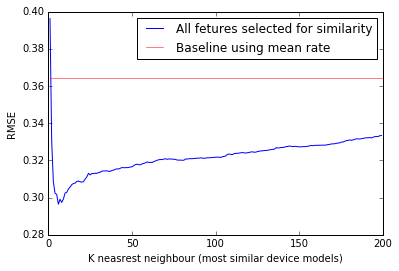

Minimum RMSE is 0.296 when N is [6]


In [41]:
"""plot RMSE vs N device models selected for n up to 200"""
import matplotlib.pyplot as plt 
%matplotlib inline
plt.ylabel('RMSE')
plt.xlabel('K neasrest neighbour (most similar device models)')

legend = ["All fetures selected for similarity", "Baseline using mean rate"]
n = [line[0] for line in RMSE_lst]
rmse = [line[1] for line in RMSE_lst]
plt.plot(n, rmse)

#plt.axhline(, xmin=1, xmax=200, linewidth=2, color = 'k')
baseline_rmse = y=math.sqrt(squared_error_average/len(lst3))

plt.plot((1, 200), (baseline_rmse, baseline_rmse), linewidth=0.5, color='r')

plt.legend(legend, loc='upper right')
plt.savefig('K_selection_9_attributes.png')
plt.show()

print("Minimum RMSE is",round(min(rmse),3), "when N is", [n[i] for i, j in enumerate(rmse) if j == min(rmse)])

In [28]:
plt.savefig('K_selection_9_attributes.png')

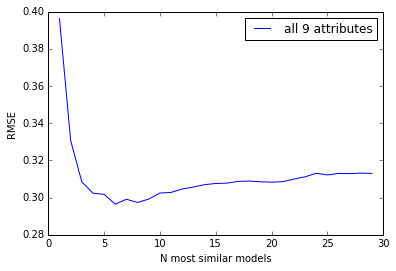

Minimum RMSE is 0.296 when N is [6]


In [108]:
"""plot RMSE vs N device models selected for n up to 30"""
import matplotlib.pyplot as plt
%matplotlib inline
plt.ylabel('RMSE')
plt.xlabel('N most similar models')

legend = ["all 9 attributes"]
n = [line[0] for line in RMSE_lst]
rmse = [line[1] for line in RMSE_lst]
plt.plot(n, rmse)

plt.legend(legend, loc='upper right')
plt.show()

print("Minimum RMSE is",round(min(rmse),3), "when N is", [n[i] for i, j in enumerate(rmse) if j == min(rmse)])